In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

In [16]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pylab
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
sns.set()

In [27]:
def LLR_Test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p
raw_csv_data = pd.read_csv("Index2018.csv")

df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst= True )
df_comp.set_index('date', inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')
df_comp['market_value'] = df_comp.ftse
del  df_comp['dax'], df_comp['nikkei'], df_comp['ftse']

size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]
df['returns'] = df.market_value.pct_change(1).mul(100)

## ARIMA(1,1,1)

In [28]:
model_ar1_i1_ma1 = ARIMA(df.market_value, order = (1,1,1))
results_ar1_i1_ma1 = model_ar1_i1_ma1.fit()
results_ar1_i1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Sun, 22 Aug 2021   AIC                          55215.333
Time:                        11:43:07   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5656      0.682      0.829      0.407      -0.772       1.903
ar.L1.D.market_value     0.7475      0.070     10.652      0.000       0.610       0.885
ma.L1.D.market_value    -0.7936      0.064    -12.378      0.000      -0.919      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3378           +0.0000j            1.3378            0.0000
MA.1            1.2601           +0.0000j            1.2601            0.0000
-----------------------------------------------------------------------------
"""

## Residuals of ARIMA(1,1,1)

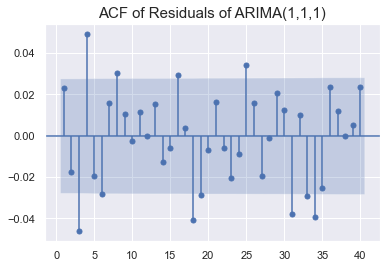

In [29]:
df['res_ar1_i1_ma1'] = results_ar1_i1_ma1.resid
sgt.plot_acf(df.res_ar1_i1_ma1[1:], zero=False, lags=40)
plt.title("ACF of Residuals of ARIMA(1,1,1)", size=15);

Third and fourth lags are significant

## Higher-Lag ARIMA Models

In [30]:
model_ar1_i1_ma2 = ARIMA(df.market_value, order = (1,1,2))
results_ar1_i1_ma2 = model_ar1_i1_ma2.fit()
model_ar1_i1_ma3 = ARIMA(df.market_value, order = (1,1,3))
results_ar1_i1_ma3 = model_ar1_i1_ma3.fit()
model_ar2_i1_ma1 = ARIMA(df.market_value, order = (2,1,1))
results_ar2_i1_ma1 = model_ar2_i1_ma1.fit()
model_ar3_i1_ma1 = ARIMA(df.market_value, order = (3,1,1))
results_ar3_i1_ma1 = model_ar3_i1_ma1.fit()
model_ar3_i1_ma2 = ARIMA(df.market_value, order = (3,1,2))
results_ar3_i1_ma2 = model_ar3_i1_ma2.fit(start_ar_lags = 5)

In [31]:
print("\n ARIMA(1,1,1) : \tLL = ", results_ar1_i1_ma1.llf, "\tAIC =",results_ar1_i1_ma1.aic)
print("\n ARIMA(1,1,2) : \tLL = ", results_ar1_i1_ma2.llf, "\tAIC =",results_ar1_i1_ma2.aic)
print("\n ARIMA(1,1,3) : \tLL = ", results_ar1_i1_ma3.llf, "\tAIC =",results_ar1_i1_ma3.aic)
print("\n ARIMA(2,1,1) : \tLL = ", results_ar2_i1_ma1.llf, "\tAIC =",results_ar2_i1_ma1.aic)
print("\n ARIMA(3,1,1) : \tLL = ", results_ar3_i1_ma1.llf, "\tAIC =",results_ar3_i1_ma1.aic)
print("\n ARIMA(3,1,2) : \tLL = ", results_ar3_i1_ma2.llf, "\tAIC =",results_ar3_i1_ma2.aic)



 ARIMA(1,1,1) : 	LL =  -27603.666412768434 	AIC = 55215.33282553687

 ARIMA(1,1,2) : 	LL =  -27600.081863116964 	AIC = 55210.16372623393

 ARIMA(1,1,3) : 	LL =  -27590.42403265391 	AIC = 55192.84806530782

 ARIMA(2,1,1) : 	LL =  -27599.807487849124 	AIC = 55209.61497569825

 ARIMA(3,1,1) : 	LL =  -27592.055371699025 	AIC = 55196.11074339805

 ARIMA(3,1,2) : 	LL =  -27590.660808972618 	AIC = 55195.321617945236


Here the ARIMA(1,1,3) has the highest LL and lowest AIC, hence is the best but (1,1,1) and (1,1,2) are nested with (1,1,3) so we should perform the LLR test to confirm that it really outperforms

In [32]:
LLR_Test(results_ar1_i1_ma2, results_ar1_i1_ma3) #This indicates that the complexity is necessary

0.0

In [33]:
LLR_Test(results_ar1_i1_ma1, results_ar1_i1_ma3, DF=2) #SO (1,1,3) appears to be the best choice out of the bunch

0.0

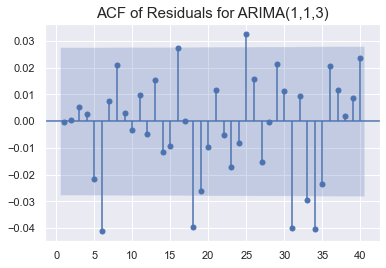

In [34]:
df['res_ar1_i1_ma3'] = results_ar1_i1_ma3.resid
sgt.plot_acf(df.res_ar1_i1_ma3[1:], zero=False, lags=40)
plt.title("ACF of Residuals for ARIMA(1,1,3)", size=15);

In [35]:
model_ar5_i1_ma1 = ARIMA(df.market_value, order = (5,1,1))
results_ar5_i1_ma1 = model_ar5_i1_ma1.fit(start_ar_lags=11)
model_ar6_i1_ma3 = ARIMA(df.market_value, order = (6,1,3))
results_ar6_i1_ma3 = model_ar6_i1_ma3.fit()

print("\n ARIMA(5,1,1) : \tLL = ", results_ar5_i1_ma1.llf, "\tAIC =",results_ar5_i1_ma1.aic)
print("\n ARIMA(6,1,3) : \tLL = ", results_ar6_i1_ma3.llf, "\tAIC =",results_ar6_i1_ma3.aic)  
print("\n ARIMA(1,1,3) : \tLL = ", results_ar1_i1_ma3.llf, "\tAIC =",results_ar1_i1_ma3.aic)


 ARIMA(5,1,1) : 	LL =  -27586.511888109162 	AIC = 55189.023776218324

 ARIMA(6,1,3) : 	LL =  -27581.45547817682 	AIC = 55184.91095635364

 ARIMA(1,1,3) : 	LL =  -27590.42403265391 	AIC = 55192.84806530782


(6,1,3) outperforms But since (1,1,3) and (5,1,1) are nested we can use LLR test to confirm that the additional complexity is worth it 

In [36]:
LLR_Test(results_ar1_i1_ma3, results_ar6_i1_ma3, DF=5) #Hence the higher complexity is rationalized as the LLR test gives a significant values 

0.003

In [37]:
LLR_Test(results_ar5_i1_ma1, results_ar6_i1_ma3, DF=3) 

0.018

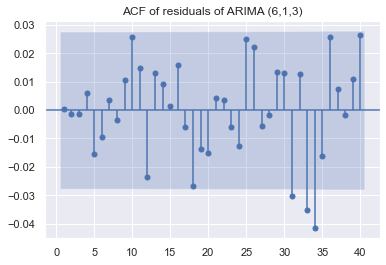

In [38]:
df['res_ar6_i1_ma3'] = results_ar6_i1_ma3.resid
sgt.plot_acf(df.res_ar6_i1_ma3[1:], zero=False, lags=40)
plt.title("ACF of residuals of ARIMA (6,1,3)");

## ARIMAX

Here we need to specify exogeneous argument called "exog"<br>
exog = array_type<br>
value associated with every time period<br>

In [42]:
model_ar1_i1_ma1_Xspx = ARIMA(df.market_value, exog=df.spx, order = (1,1,1)) #spx does not have a significant coefficient 
results_ar1_i1_ma1_Xspx = model_ar1_i1_ma1_Xspx.fit()                        # We can test the multiple variables as exog
results_ar1_i1_ma1_Xspx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.556
Method:                       css-mle   S.D. of innovations             59.132
Date:                Sun, 22 Aug 2021   AIC                          55217.112
Time:                        11:50:36   BIC                          55249.718
Sample:                    01-10-1994   HQIC                         55228.538
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5868      2.655     -0.221      0.825      -5.791       4.618
spx                      0.0011      0.002      0.450      0.652      -0.004       0.006
ar.L1.D.market_value     0.7456      0.070     10.578      0.000       0.607       0.884
ma.L1.D.market_value    -0.7917      0.065    -12.274      0.000      -0.918      -0.665
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3412           +0.0000j            1.3412            0.0000
MA.1            1.2632           +0.0000j            1.2632            0.0000
-----------------------------------------------------------------------------
"""

## SARIMAX

In [44]:
model_sarimax = SARIMAX(df.market_value, exog=df.spx, order = (1,0,1), seasonal_order=(2,0,1,5)) 
results_sarimax = model_sarimax.fit()                        
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      market_value   No. Observations:                 5021
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -26712.673
Date:                           Sun, 22 Aug 2021   AIC                          53439.345
Time:                                   12:02:31   BIC                          53484.995
Sample:                               01-07-1994   HQIC                         53455.341
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.7032      0.035     76.693      0.000       2.634       2.772
ar.L1          0.9998      0.000   2252.712      0.000       0.999       1.001
ma.L1         -0.3114      0.009    -32.948      0.000      -0.330      -0.293
ar.S.L5        0.9663      0.011     87.513      0.000       0.945       0.988
ar.S.L10       0.0333      0.010      3.250      0.001       0.013       0.053
ma.S.L5       -0.9988      0.006   -172.461      0.000      -1.010      -0.987
sigma2      2440.6630     28.645     85.204      0.000    2384.520    2496.806
===================================================================================
Ljung-Box (Q):                       95.56   Jarque-Bera (JB):              4207.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARCH (Autoregressive Conditional Heteroskedasticity Model)

Creating squred returns

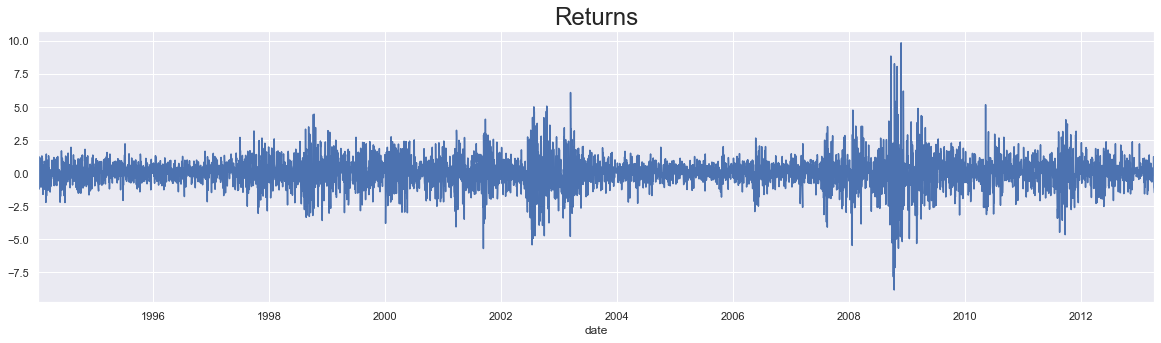

In [46]:
df['sq_returns'] = df.returns.mul(df.returns)
df.returns.plot(figsize=(20,5))
plt.title("Returns", size=24)
plt.show()

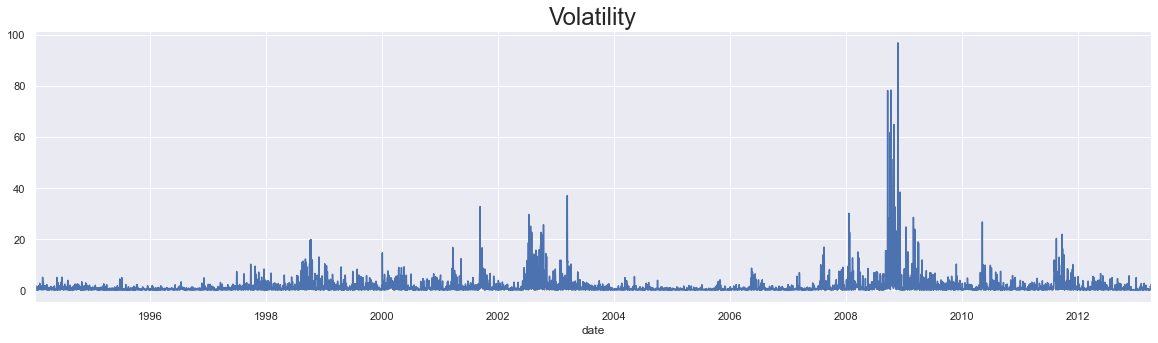

In [47]:
df.sq_returns.plot(figsize=(20,5))
plt.title("Volatility", size=24)
plt.show()

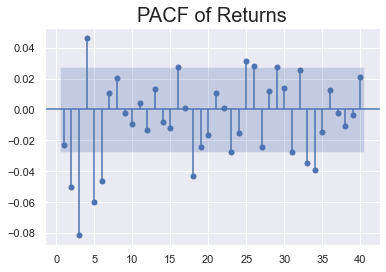

In [48]:
sgt.plot_pacf(df.returns[1:], zero=False, lags=40, alpha=0.05, method=('ols'))
plt.title("PACF of Returns", size=20)
plt.show()

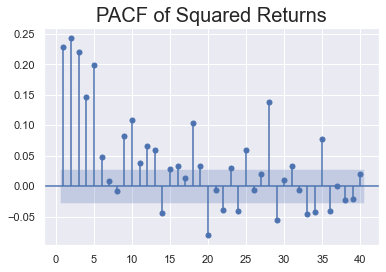

In [49]:
sgt.plot_pacf(df.sq_returns[1:], zero=False, lags=40, alpha=0.05, method=('ols'))
plt.title("PACF of Squared Returns", size=20)
plt.show()